In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
from tqdm import *


In [105]:
img_list_path = "C:\\Users\\amith\\Documents\\Datasets\\10 - Land Segmentation using U-Net Architecture"

img_list = os.listdir(img_list_path)

terrain_img_list = list(map(lambda x: x if "_t" in x else None,img_list))
while None in terrain_img_list:
    terrain_img_list.remove(None)
terrain_img_list.sort()

height_img_list = list(map(lambda x: x if "_h" in x else None,img_list))
while None in height_img_list:
    height_img_list.remove(None)
height_img_list.sort()

segmented_img_list = list(map(lambda x: x if "_i2" in x else None,img_list))
while None in segmented_img_list:
    segmented_img_list.remove(None)
segmented_img_list.sort()

print(len(terrain_img_list))
print(len(height_img_list))
print(len(segmented_img_list))


5000
5000
5000


In [140]:
cv2.imread(img_list_path + "\\" + terrain_img_list[0]).shape


(512, 512, 3)

In [106]:
print(terrain_img_list[0:5])
print(height_img_list[0:5])
print(segmented_img_list[0:5])


['0001_t.png', '0002_t.png', '0003_t.png', '0004_t.png', '0005_t.png']
['0001_h.png', '0002_h.png', '0003_h.png', '0004_h.png', '0005_h.png']
['0001_i2.png', '0002_i2.png', '0003_i2.png', '0004_i2.png', '0005_i2.png']


In [115]:
X = []
y = []
for i in tqdm(range(len(terrain_img_list))):

    terrain_img = cv2.imread(filename=img_list_path + "\\" + terrain_img_list[i])
    segmented_img = cv2.imread(filename=img_list_path + "\\" + segmented_img_list[i])

    terrain_img_resized = cv2.resize(terrain_img,(64,64))
    segmented_img_resized = cv2.resize(segmented_img,(64,64))

    terrain_img_scaled = terrain_img_resized / 255.0
    segmented_img_scaled = segmented_img_resized / 255.0

    X.append(terrain_img_scaled)
    y.append(segmented_img_scaled)
X = np.array(X)
y = np.array(y)


100%|██████████| 5000/5000 [00:42<00:00, 116.35it/s]


In [116]:
img_indices = np.array(range(len(X)))
np.random.shuffle(img_indices)

val_test_threshold = int(0.8 * len(img_indices))
train_val_threshold = int(0.8 * val_test_threshold)

train_indices = img_indices[:train_val_threshold]
val_indices = img_indices[train_val_threshold:val_test_threshold]
test_indices = img_indices[val_test_threshold:]

X_train = X[train_indices]
X_val = X[val_indices]
X_test = X[test_indices]

y_train = y[train_indices]
y_val = y[val_indices]
y_test = y[test_indices]


In [117]:
X_train[0].shape


(64, 64, 3)

In [119]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation="relu",padding="same",input_shape=(64,64,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"), #1

    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu",padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"), #2

    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu",padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"), #3

    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu",padding="same"),
    tf.keras.layers.UpSampling2D(size=(2,2)), #4

    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu",padding="same"),
    tf.keras.layers.UpSampling2D(size=(2,2)), #5

    tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation="relu",padding="same"),
    tf.keras.layers.UpSampling2D(size=(2,2)), #6

    tf.keras.layers.Conv2D(filters=3,kernel_size=(3,3),activation="sigmoid",padding="same"), #7
])


In [120]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.mean_absolute_error,metrics=["accuracy"])


In [124]:
model.fit(x=X_train,y=y_train,epochs=100,verbose=1,callbacks=tf.keras.callbacks.EarlyStopping(patience=2),validation_data=(X_val,y_val))


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8086 - loss: 0.0559 - val_accuracy: 0.8125 - val_loss: 0.0532
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8127 - loss: 0.0530 - val_accuracy: 0.8277 - val_loss: 0.0546
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8007 - loss: 0.0544 - val_accuracy: 0.7715 - val_loss: 0.0552


In [127]:
y_pred = model.predict(X_test)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


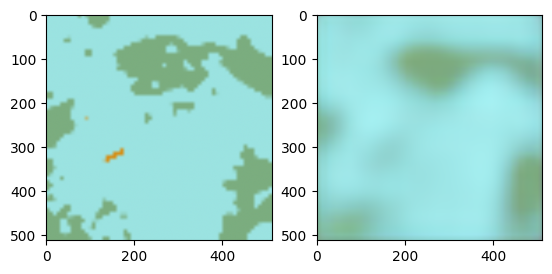

In [146]:
fig,ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(cv2.resize(y_test[1],(512,512)))
ax[1].imshow(cv2.resize(y_pred[1],(512,512)))


In [148]:
tf.keras.models.save_model(model=model,filepath="C:\\Users\\amith\\Documents\\GitHub\\udemy\\10 - Land Segmentation using U-Net Architecture\\ML_model\\TerrainMaskGenerator.h5")

tf.keras.models.save_model(model=model,filepath="C:\\Users\\amith\\Documents\\GitHub\\udemy\\10 - Land Segmentation using U-Net Architecture\\app\\TerrainMaskGenerator.h5")
